# Pré-processamento

## Carregando os dados

In [0]:
data = spark.table("hive_metastore.default.base_dados_treino")
data.show(5)

+--------------------+---------------------------+--------------------+
|    ANALISE_RESPOSTA|Sacl Cod Texto Manifestacao|   Sacl Texto Tarefa|
+--------------------+---------------------------+--------------------+
|Devolvido - Falta...|       Pedido de informa...|Não foi possível ...|
|Devolvido - Falta...|       Cliente reporta p...|Cliente não dispo...|
|Devolvido - Respo...|       Cliente confuso s...|Necessário agenda...|
|Devolvido - Respo...|       Pedido de revisão...|Necessário agenda...|
|Devolvido - Falta...|       Pedido de assistê...|E-mail retornado,...|
+--------------------+---------------------------+--------------------+
only showing top 5 rows



## Tratamento

In [0]:
import unicodedata
import re

def preprocess_text(text):
    # converte para minusculas
    text = text.lower()
    # remoção de acentos
    text = ''.join(c for c in unicodedata.normalize('NFKD', text))
    # remoção de números, pontuações e símbolos especiais
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # remoção de espaços em branco
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [0]:
from pyspark.sql.functions import concat_ws, col, udf
from pyspark.sql.types import StringType

# Com a coluna de texto manifestação combinada
data = data.withColumn(
  "combined_text", concat_ws(" ", col("Sacl Cod Texto Manifestacao"), col("Sacl Texto Tarefa"))
  )

# # Sem a coluna de texto manifestação combinada
# data = data.withColumn(
#   "combined_text", concat_ws(" ", col("Sacl Texto Tarefa"))
#   )

preprocess_text_udf = udf(preprocess_text, StringType())

data = data.withColumn('clean_text', preprocess_text_udf(col('combined_text')))

display(data)

ANALISE_RESPOSTA,Sacl Cod Texto Manifestacao,Sacl Texto Tarefa,combined_text,clean_text
Devolvido - Falta de contato,Pedido de informações sobre nova fatura.,Não foi possível contatar o cliente nos horários informados.,Pedido de informações sobre nova fatura. Não foi possível contatar o cliente nos horários informados.,pedido de informacoes sobre nova fatura nao foi possivel contatar o cliente nos horarios informados
Devolvido - Falta de contato,Cliente reporta problemas de acesso ao sistema.,Cliente não disponível no momento do contato.,Cliente reporta problemas de acesso ao sistema. Cliente não disponível no momento do contato.,cliente reporta problemas de acesso ao sistema cliente nao disponivel no momento do contato
Devolvido - Resposta inconclusiva,Cliente confuso sobre mudanças no serviço.,Necessário agendamento de visita técnica não realizado.,Cliente confuso sobre mudanças no serviço. Necessário agendamento de visita técnica não realizado.,cliente confuso sobre mudancas no servico necessario agendamento de visita tecnica nao realizado
Devolvido - Resposta inconclusiva,Pedido de revisão de contrato.,Necessário agendamento de visita técnica não realizado.,Pedido de revisão de contrato. Necessário agendamento de visita técnica não realizado.,pedido de revisao de contrato necessario agendamento de visita tecnica nao realizado
Devolvido - Falta de contato,Pedido de assistência para configuração de equipamento.,"E-mail retornado, endereço de e-mail incorreto.","Pedido de assistência para configuração de equipamento. E-mail retornado, endereço de e-mail incorreto.",pedido de assistencia para configuracao de equipamento email retornado endereco de email incorreto
Devolvido - Resposta inconclusiva,Solicitação de reembolso por cobrança indevida.,Solução proposta não é aplicável ao caso.,Solicitação de reembolso por cobrança indevida. Solução proposta não é aplicável ao caso.,solicitacao de reembolso por cobranca indevida solucao proposta nao e aplicavel ao caso
Devolvido - Falta de contato,Cliente pede suporte técnico urgente.,"E-mail retornado, endereço de e-mail incorreto.","Cliente pede suporte técnico urgente. E-mail retornado, endereço de e-mail incorreto.",cliente pede suporte tecnico urgente email retornado endereco de email incorreto
Devolvido - Resposta inconclusiva,Cliente questiona aumento na tarifa do serviço.,Cliente considera a resposta insatisfatória.,Cliente questiona aumento na tarifa do serviço. Cliente considera a resposta insatisfatória.,cliente questiona aumento na tarifa do servico cliente considera a resposta insatisfatoria
Devolvido - Falta de contato,Solicitação de informações sobre garantia estendida.,"E-mail retornado, endereço de e-mail incorreto.","Solicitação de informações sobre garantia estendida. E-mail retornado, endereço de e-mail incorreto.",solicitacao de informacoes sobre garantia estendida email retornado endereco de email incorreto
Resposta Completa,Cliente elogia a rapidez na resolução do problema.,Suporte técnico fornecido com sucesso.,Cliente elogia a rapidez na resolução do problema. Suporte técnico fornecido com sucesso.,cliente elogia a rapidez na resolucao do problema suporte tecnico fornecido com sucesso


## Indexação e tokenização

In [0]:
from pyspark.ml.feature import StringIndexer, Tokenizer, NGram, HashingTF, IDF, StopWordsRemover
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

In [0]:
# Indexar a coluna de rótulos
indexer = StringIndexer(inputCol="ANALISE_RESPOSTA", outputCol="ANALISE_RESPOSTA_INDEX")
data = indexer.fit(data).transform(data)

data.select("ANALISE_RESPOSTA", "ANALISE_RESPOSTA_INDEX") \
    .distinct() \
    .show(5, truncate=False)

+---------------------------------+----------------------+
|ANALISE_RESPOSTA                 |ANALISE_RESPOSTA_INDEX|
+---------------------------------+----------------------+
|Devolvido - Resposta inconclusiva|2.0                   |
|Resposta Completa                |1.0                   |
|Devolvido - Falta de contato     |0.0                   |
+---------------------------------+----------------------+



In [0]:
# Tokenização
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
data = tokenizer.transform(data)

data.select("words").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+
|words                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------+
|[pedido, de, informacoes, sobre, nova, fatura, nao, foi, possivel, contatar, o, cliente, nos, horarios, informados]|
|[cliente, reporta, problemas, de, acesso, ao, sistema, cliente, nao, disponivel, no, momento, do, contato]         |
|[cliente, confuso, sobre, mudancas, no, servico, necessario, agendamento, de, visita, tecnica, nao, realizado]     |
|[pedido, de, revisao, de, contrato, necessario, agendamento, de, visita, tecnica, nao, realizado]                  |
|[pedido, de, assistencia, para, configuracao, de, equipamento, email, retornado, endereco, de, email, incorreto]   |
+-------------------------------------------------------

## Remoção de stopwords

In [0]:
def remove_accents(words):
    return [unicodedata.normalize('NFKD', word).encode('ASCII', 'ignore').decode('utf-8') for word in words]

In [0]:
stopwords_ignore = ["nao", "nunca"] # desconsiderei essas para não fugir do contexto

stopwords_portugues = StopWordsRemover.loadDefaultStopWords("portuguese")
stopwords_sem_acento = remove_accents(stopwords_portugues)
stopwords_tratadas = [word for word in stopwords_sem_acento if word not in stopwords_ignore]
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
remover = remover.setStopWords(stopwords_tratadas)
data = remover.transform(data)

stopwords_tratadas

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'a',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'ja',
 'eu',
 'tambem',
 'so',
 'pelo',
 'pela',
 'ate',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'voce',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'as',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nos',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'voces',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'esta',
 'estamos',
 'estao',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estavamos',
 'estavam',
 'estivera',
 'estiveramo

## Criação de bigrams com n-grams

In [0]:
# Criar bigrams
ngram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
data = ngram.transform(data)

display(data.select("bigrams").limit(5))

bigrams
"List(pedido informacoes, informacoes sobre, sobre nova, nova fatura, fatura nao, nao possivel, possivel contatar, contatar cliente, cliente horarios, horarios informados)"
"List(cliente reporta, reporta problemas, problemas acesso, acesso sistema, sistema cliente, cliente nao, nao disponivel, disponivel momento, momento contato)"
"List(cliente confuso, confuso sobre, sobre mudancas, mudancas servico, servico necessario, necessario agendamento, agendamento visita, visita tecnica, tecnica nao, nao realizado)"
"List(pedido revisao, revisao contrato, contrato necessario, necessario agendamento, agendamento visita, visita tecnica, tecnica nao, nao realizado)"
"List(pedido assistencia, assistencia configuracao, configuracao equipamento, equipamento email, email retornado, retornado endereco, endereco email, email incorreto)"


In [0]:
# TF-IDF com bigrams
hashingTF = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=10000)
featurizedData = hashingTF.transform(data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
data = idfModel.transform(featurizedData)

data.select("rawFeatures").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------+
|rawFeatures                                                                                         |
+----------------------------------------------------------------------------------------------------+
|(10000,[888,2380,2974,3816,3875,4970,6774,8000,8538,8649],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(10000,[1034,2229,3168,3449,4169,6166,7972,8509,9747],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])        |
|(10000,[262,1122,1900,3703,3974,4889,6867,6902,8944,9137],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(10000,[3703,3762,4889,5768,6739,6867,8944,9137],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                 |
|(10000,[36,1262,1376,4066,4624,7553,9014,9878],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                   |
+----------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [0]:
!pip install nltk spacy
!python -m spacy download pt_core_news_sm

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 33.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


## Lematização

In [0]:
import spacy

nlp = spacy.load('pt_core_news_sm')

def lemmatize_words_pt(words):
    return [token.lemma_ for token in nlp(" ".join(words))]

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemmatize_udf_pt = udf(lemmatize_words_pt, ArrayType(StringType()))
data = data.withColumn("lemmatized_words", lemmatize_udf_pt(col("filtered_words")))

data.select("lemmatized_words").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------+
|lemmatized_words                                                                                    |
+----------------------------------------------------------------------------------------------------+
|[pedir, informacoes, sobre, novo, fatura, nao, possivel, contatar, cliente, horario, informar]      |
|[cliente, reporta, problema, acesso, sistema, cliente, nao, disponivel, momento, contato]           |
|[cliente, confuso, sobre, mudanca, servico, necessario, agendamento, visita, tecnico, nao, realizar]|
|[pedir, revisao, contrato, necessario, agendamento, visita, tecnico, nao, realizar]                 |
|[pedir, assistencia, configuracao, equipamento, email, retornar, endereco, email, incorreto]        |
+----------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [0]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Frequência de palavras

In [0]:
from pyspark.sql.functions import explode, count

# Explodir palavras para contar frequência
word_freq = data.withColumn("word", explode(col("lemmatized_words"))) \
                .groupBy("word") \
                .agg(count("word").alias("frequency"))
display(word_freq.orderBy(col("frequency").desc()))

word,frequency
cliente,1911
nao,855
sobre,658
solicitacao,546
pedir,476
informacoes,350
atender,242
servico,238
resposta,229
problema,226


In [0]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/40/ad/c22887189c23cc133ae7cbad48c71312f1a962b960fe7f51fd792808a307/wordcloud-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/548.3 kB ? eta -:--:--
   ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/548.3 kB 5.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 542.7/548.3 kB 8.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
top_words = word_freq.orderBy(col("frequency").desc()).limit(20)
top_words_df = top_words.toPandas()

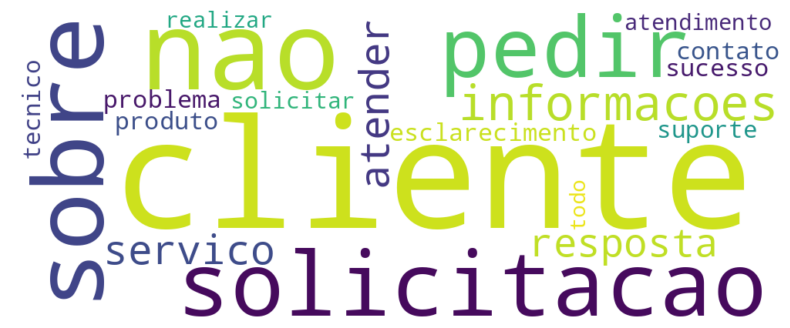

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Cria um dicionário de palavras e suas frequências
word_freq_dict = dict(zip(top_words_df['word'], top_words_df['frequency']))

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=1000, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # remover eixos
plt.show()

In [0]:
# Filtrar palavras de baixa frequência
low_freq_words = word_freq.filter(col("frequency") < 5).select("word").rdd.flatMap(lambda x: x).collect()

low_freq_words

['informacoe',
 'faturar',
 'correspondencia',
 'desbloqueio',
 'fisic',
 'resposto',
 'elogia',
 'indevir',
 'devolucaor',
 'atendidar',
 'estendido',
 'contraditorio',
 'emails',
 'estendida']

In [0]:
# Função para remover palavras raras
def remove_low_freq(words):
    return [word for word in words if word not in low_freq_words]
  
remove_low_freq_udf = udf(remove_low_freq, ArrayType(StringType()))

data = data.withColumn("final_words", remove_low_freq_udf(col("lemmatized_words")))
data.select("final_words").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------+
|final_words                                                                                         |
+----------------------------------------------------------------------------------------------------+
|[pedir, informacoes, sobre, novo, fatura, nao, possivel, contatar, cliente, horario, informar]      |
|[cliente, reporta, problema, acesso, sistema, cliente, nao, disponivel, momento, contato]           |
|[cliente, confuso, sobre, mudanca, servico, necessario, agendamento, visita, tecnico, nao, realizar]|
|[pedir, revisao, contrato, necessario, agendamento, visita, tecnico, nao, realizar]                 |
|[pedir, assistencia, configuracao, equipamento, email, retornar, endereco, email, incorreto]        |
+----------------------------------------------------------------------------------------------------+
only showing top 5 rows



## Treino/teste

In [0]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [0]:
train_data.groupBy("ANALISE_RESPOSTA").count().show(truncate=False)
print(f'Tamanho da base de treino: {train_data.count()}')

+---------------------------------+-----+
|ANALISE_RESPOSTA                 |count|
+---------------------------------+-----+
|Resposta Completa                |532  |
|Devolvido - Resposta inconclusiva|532  |
|Devolvido - Falta de contato     |578  |
+---------------------------------+-----+

Tamanho da base de treino: 1642


In [0]:
test_data.groupBy("ANALISE_RESPOSTA").count().show(truncate=False)
print(f'Tamanho da base de teste: {test_data.count()}')

+---------------------------------+-----+
|ANALISE_RESPOSTA                 |count|
+---------------------------------+-----+
|Resposta Completa                |127  |
|Devolvido - Resposta inconclusiva|121  |
|Devolvido - Falta de contato     |110  |
+---------------------------------+-----+

Tamanho da base de teste: 358


## Classes e features

In [0]:
# Número de classes no label
num_classes = train_data.select("ANALISE_RESPOSTA_INDEX").distinct().count()

# Número de features
from pyspark.ml.linalg import Vectors
num_features = len(train_data.select("features").first()[0])

print(f"classes: {num_classes}\nfeatures: {num_features}")

classes: 3
features: 10000


In [0]:
display(train_data.select("features").limit(5))

features
"Map(vectorType -> sparse, length -> 10000, indices -> List(2156, 3902, 4751, 5200, 6790, 7331, 8742, 9985), values -> List(3.912522880469797, 4.135666431784007, 4.711030576687569, 2.9379632404716665, 4.135666431784007, 3.912522880469797, 3.912522880469797, 4.135666431784007))"
"Map(vectorType -> sparse, length -> 10000, indices -> List(2156, 3902, 4751, 5200, 6790, 7331, 8742, 9985), values -> List(3.912522880469797, 4.135666431784007, 4.711030576687569, 2.9379632404716665, 4.135666431784007, 3.912522880469797, 3.912522880469797, 4.135666431784007))"
"Map(vectorType -> sparse, length -> 10000, indices -> List(2156, 3902, 4751, 5200, 6790, 7331, 8742, 9985), values -> List(3.912522880469797, 4.135666431784007, 4.711030576687569, 2.9379632404716665, 4.135666431784007, 3.912522880469797, 3.912522880469797, 4.135666431784007))"
"Map(vectorType -> sparse, length -> 10000, indices -> List(2156, 4751, 5105, 5200, 5270, 6012, 7138, 7331, 8742), values -> List(3.912522880469797, 4.711030576687569, 3.7947398448134138, 2.9379632404716665, 3.751254732873675, 3.7947398448134138, 3.7947398448134138, 3.912522880469797, 3.912522880469797))"
"Map(vectorType -> sparse, length -> 10000, indices -> List(2156, 4751, 5105, 5200, 5270, 6012, 7138, 7331, 8742), values -> List(3.912522880469797, 4.711030576687569, 3.7947398448134138, 2.9379632404716665, 3.751254732873675, 3.7947398448134138, 3.7947398448134138, 3.912522880469797, 3.912522880469797))"


## Pipeline de modelos

In [0]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

results = []

# Definindo o avaliador
evaluator = MulticlassClassificationEvaluator(labelCol="ANALISE_RESPOSTA_INDEX", predictionCol="prediction", metricName="accuracy")

# Estrutura da rede neural: 4 nós na entrada, duas camadas ocultas com 5 e 4 nós, e 3 nós na saída
layers = [num_features, 5, 4, num_classes]

# Modelos a serem testados
models = {
    "Logistic Regression": LogisticRegression(featuresCol='features', labelCol='ANALISE_RESPOSTA_INDEX'),
    "Random Forest": RandomForestClassifier(featuresCol='features', labelCol='ANALISE_RESPOSTA_INDEX'),
    "Naive Bayes": NaiveBayes(featuresCol='features', labelCol='ANALISE_RESPOSTA_INDEX'),
    "Neural Network": MultilayerPerceptronClassifier(featuresCol='features', labelCol='ANALISE_RESPOSTA_INDEX', layers=layers, blockSize=128, maxIter=100)
}

trained_models = {}

# Treinamento e avaliação
for model_name, model in models.items():
    # Treinando o modelo
    trained_model = model.fit(train_data)

    # Armazenando o modelo treinado
    trained_models[model_name] = trained_model
    
    # Previsões no conjunto de teste
    predictions = trained_model.transform(test_data)
    
    # Calculando a acurácia
    accuracy = evaluator.evaluate(predictions)
    
    # Armazenando o resultado
    results.append((model_name, accuracy))

# Convertendo resultados para DataFrame
results_df = spark.createDataFrame(results, ["Model", "Accuracy"])
results_df.show()

+-------------------+-----------------+
|              Model|         Accuracy|
+-------------------+-----------------+
|Logistic Regression|              1.0|
|      Random Forest|0.888268156424581|
|        Naive Bayes|              1.0|
|     Neural Network|              1.0|
+-------------------+-----------------+



## Acurácia

In [0]:
best_model = max(results, key=lambda x: x[1])
print(f"Melhor modelo: {best_model[0]} com acurácia de {best_model[1]:.2f}")

Melhor modelo: Logistic Regression com acurácia de 1.00


## Save model

In [0]:
# Seleção do melhor modelo com base nos resultados
best_model_name = best_model[0]
final_model = trained_models[best_model_name]

# Salvando o melhor modelo
final_model.write().overwrite().save("dbfs:/models/best_classification_model")